# GRU Model

##### Step 1. Import modules and load dataset

In [1]:
#Import required Libraries

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv('HSG Historical Data.csv',delimiter=",", thousands=',')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,21800.0,21700.0,21900.0,21450.0,6.02M,1.16%
1,05/30/2024,21550.0,21500.0,21800.0,21350.0,7.18M,-1.37%
2,05/29/2024,21850.0,22200.0,22400.0,21750.0,10.03M,-0.91%
3,05/28/2024,22050.0,22150.0,22150.0,21900.0,7.26M,0.23%
4,05/27/2024,22000.0,21500.0,22000.0,21400.0,6.74M,2.09%
...,...,...,...,...,...,...,...
1308,03/07/2019,6034.4,6237.7,6277.1,6034.4,9.73M,-3.87%
1309,03/06/2019,6277.1,6473.8,6559.1,6106.5,15.89M,-3.43%
1310,03/05/2019,6500.1,6559.1,6821.5,6401.7,16.02M,-0.40%
1311,03/04/2019,6526.3,6421.4,6526.3,6231.1,14.78M,6.99%


In [3]:
# Determine the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1313 non-null   object 
 1   Price     1313 non-null   float64
 2   Open      1313 non-null   float64
 3   High      1313 non-null   float64
 4   Low       1313 non-null   float64
 5   Vol.      1313 non-null   object 
 6   Change %  1313 non-null   object 
dtypes: float64(4), object(3)
memory usage: 71.9+ KB


##### Step 2. Selecting attribute

In [4]:
df = df[['Price']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Price
0,21800.0
1,21550.0
2,21850.0
3,22050.0
4,22000.0
...,...
1308,6034.4
1309,6277.1
1310,6500.1
1311,6526.3


In [5]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

##### Step 3. Split the dataset into train, test, validate

In [6]:
# Calculate the number of samples for each set
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1181
Test data size: 132


Step 4. Reshape input

In [7]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [8]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
train_last_windowsize = train_data[-time_step-1:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [9]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

##### Step 5. Process of training the model

In [10]:
# Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 6s 52ms/step - loss: 0.0553
Epoch 2/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0096
Epoch 3/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0032
Epoch 4/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0010
Epoch 5/100
17/17 [==============================] - 1s 79ms/step - loss: 6.1469e-04
Epoch 6/100
17/17 [==============================] - 1s 51ms/step - loss: 5.8041e-04
Epoch 7/100
17/17 [==============================] - 1s 51ms/step - loss: 5.3876e-04
Epoch 8/100
17/17 [==============================] - 1s 54ms/step - loss: 5.3231e-04
Epoch 9/100
17/17 [==============================] - 1s 55ms/step - loss: 5.2209e-04
Epoch 10/100
17/17 [==============================] - 1s 55ms/step - loss: 5.0992e-04
Epoch 11/100
17/17 [==============================] - 1s 54ms/step - loss: 4.9312e-04
Epoch 12/100
17/17 [==============================] - 1s 52ms/step - loss: 4.77

In [11]:
# Forecast test data
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

# Standardize y_pred data
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)



5/5 [==============================] - 0s 20ms/step


##### Step 6. Evaluate the accuracy of test sets

In [12]:
# Actual values of the test set
y_test1 = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('RMSE:', test_rmse)

# MAPE
mape_test = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('MAPE:', mape_test)

# MAE
mae_test = np.mean(np.abs(y_test1 - y_pred))
print("MAE:", mae_test)

RMSE: 127.321224223519
MAPE: 1.6433292456692932
MAE: 91.93191213896777


##### Step 7. Forecasting

In [13]:
# 13. Dự báo 90 ngày tiếp theo dựa trên dữ liệu test
x_input = test_data[60:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = x_input.shape[1]
i = 0
while i < 90:

    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

[0.07941978]
73
1 day input [0.06072574 0.06091393 0.06242208 0.06034674 0.05827402 0.05827402
 0.06072574 0.0616667  0.06147851 0.0675137  0.07015361 0.07241714
 0.07336071 0.0707208  0.06807828 0.06902185 0.06807828 0.06770189
 0.06789009 0.06732551 0.06902185 0.07015361 0.0707208  0.06902185
 0.06713732 0.06506199 0.06732551 0.06789009 0.06789009 0.07184995
 0.07166176 0.06506199 0.06430661 0.06487379 0.05940579 0.05940579
 0.0552891  0.04620363 0.05220485 0.06249003 0.0707208  0.07003338
 0.06951846 0.0712331  0.07157812 0.07329014 0.07294773 0.07346265
 0.07089069 0.07140561 0.07534979 0.07723432 0.07260533 0.06951846
 0.07020589 0.07466237 0.07192052 0.0710632  0.07037578 0.07397756
 0.06969097 0.07534979 0.07192052 0.07620449 0.07963376 0.07277784
 0.07192052 0.07826414 0.08409285 0.08477766 0.07363515 0.07941978]
1 day output [[0.08020701]]
2 day input [0.06091393 0.06242208 0.06034674 0.05827402 0.05827402 0.06072574
 0.0616667  0.06147851 0.0675137  0.07015361 0.07241714 0.07

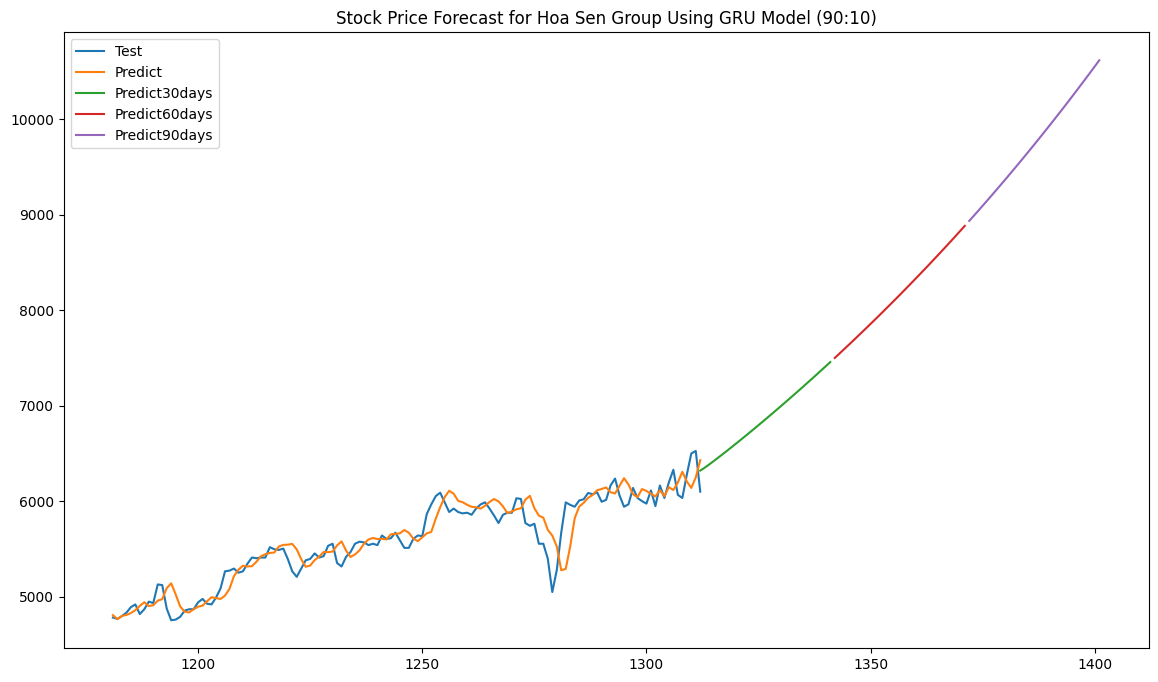

In [14]:
plt.figure(figsize=(14, 8))

# Vẽ dữ liệu kiểm tra (test_data)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
test_pred_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_pred_index, y_pred, label='Predict')

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_90[:30]), label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_90[30:60]), label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

# Thêm chú thích và hiển thị đồ thị
plt.title('Stock Price Forecast for Hoa Sen Group Using GRU Model (90:10)')
plt.legend(['Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()


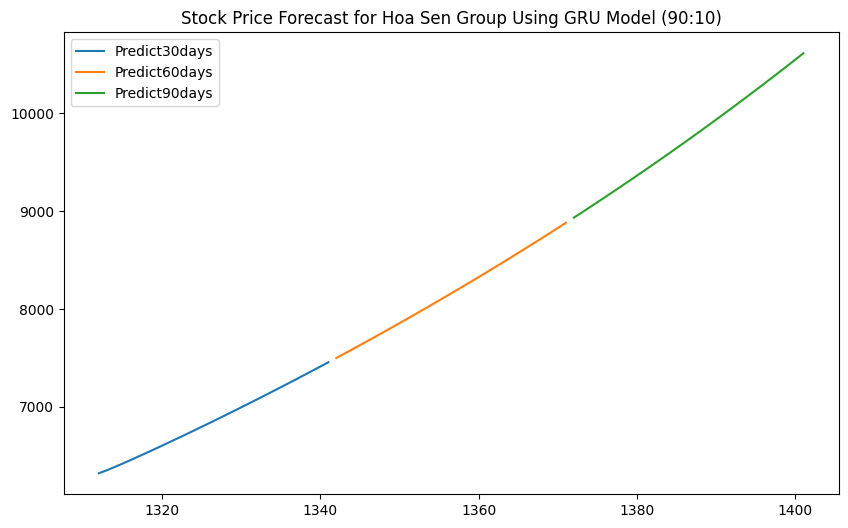

In [15]:
plt.figure(figsize=(10, 6))

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_90[:30]), label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_90[30:60]), label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

plt.title('Stock Price Forecast for Hoa Sen Group Using GRU Model (90:10)')
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()